In [1]:
import pandas as pd
import torch
import torch.optim as optim
from torch.utils.data import DataLoader

from stat3007_timeseries_forecasting.utils import get_data_dir, get_sequences_multiple_tickers

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: mps


In [2]:
#Load the dataset
data = pd.read_csv(get_data_dir() + 'energy_sector_dataset.csv')
data

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,Scaled_close
0,2022-05-13,17.600000,18.950001,17.600000,18.110001,18.110001,6325600,ACDC,0.198526
1,2022-05-16,18.000000,18.590000,17.160000,17.990000,17.990000,1283600,ACDC,0.185887
2,2022-05-17,18.219999,18.370001,17.680000,18.080000,18.080000,898000,ACDC,0.195366
3,2022-05-18,18.049999,18.299999,17.770000,17.980000,17.980000,790800,ACDC,0.184834
4,2022-05-19,17.820000,18.000000,16.750000,16.879999,16.879999,2122300,ACDC,0.068984
...,...,...,...,...,...,...,...,...,...
163279,2024-04-29,150.509995,152.809998,147.580002,151.070007,151.070007,1214500,WWD,0.786395
163280,2024-04-30,162.229996,169.990005,160.000000,162.360001,162.360001,1309200,WWD,0.922183
163281,2024-05-01,161.630005,168.770004,161.149994,165.860001,165.860001,778500,WWD,0.964279
163282,2024-05-02,166.199997,168.389999,165.000000,167.990005,167.990005,486500,WWD,0.989897


In [3]:
train_sequences, test_sequences = get_sequences_multiple_tickers(data, input_sequence_length=50, train_percentage=0.8, test_offset=5)

In [4]:
#Get the model and initialize it with multistep prediction
from stat3007_timeseries_forecasting.lstm.models import ForeCastModel

hidden_dim = 256
num_layers = 1
future_steps = 5    #I.e how many steps are we predicting per look.

model = ForeCastModel(input_dim=1, hidden_dim=hidden_dim, num_layers=num_layers, output_dim=future_steps, device=device).to(device)
print(model)

ForeCastModel(
  (lstm): LSTM(1, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=5, bias=True)
)


In [5]:
from stat3007_timeseries_forecasting.dataset import SequenceDataset
# Hyperparams
batch_size = 32
lr = 0.01
num_epochs = 1

train_dataset = SequenceDataset(train_sequences)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.MSELoss(reduction='mean')

In [6]:
from stat3007_timeseries_forecasting.utils import train
train(model, optimizer, train_dataloader, num_epochs, criterion, prediction_horizon=5)

Epoch 1/1: 100%|████████████████████████████████████████████████| 4015/4015 [00:40<00:00, 98.24it/s]

Epoch 1/1, Average Loss: 0.0076902813


In [7]:
from stat3007_timeseries_forecasting.utils import test_model

In [8]:
predictions = test_model(model, test_sequences, oneshot_multistep=True)

Testing metrics: RMSE_1: 0.024326096523179703, RMSE_3 0.02907715732344441, RMSE_5 0.032635914606432274


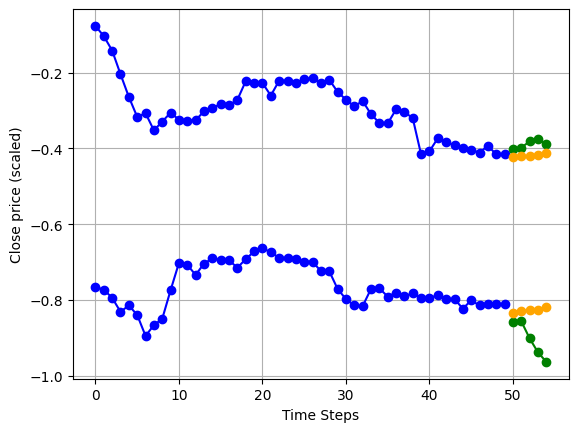

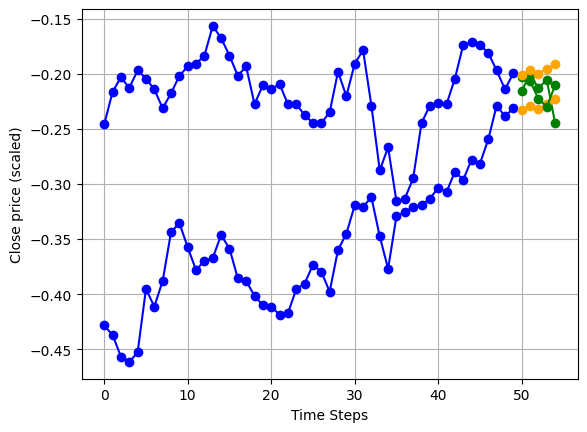

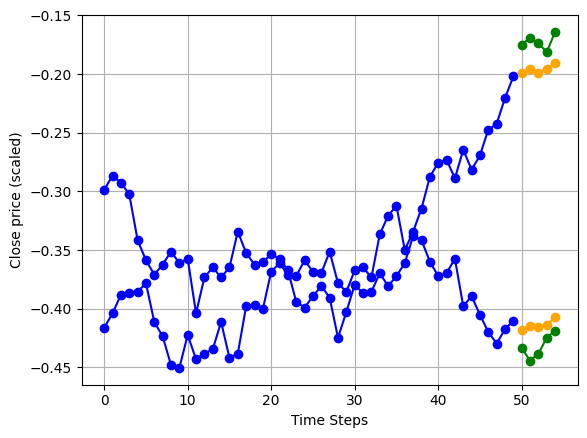

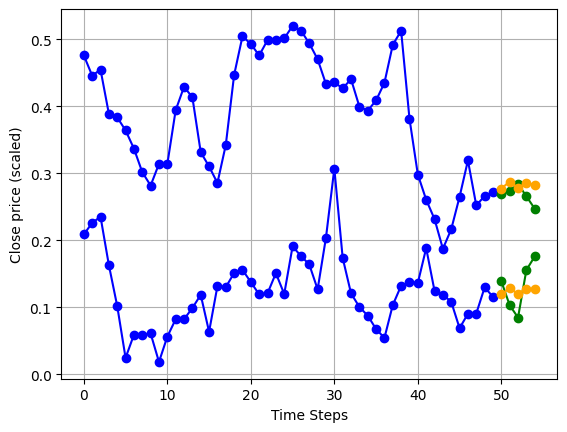

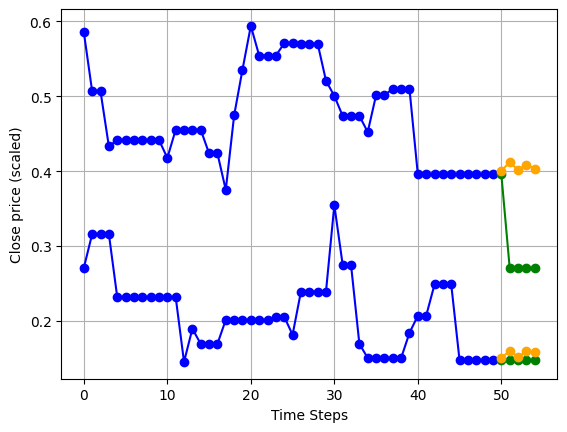

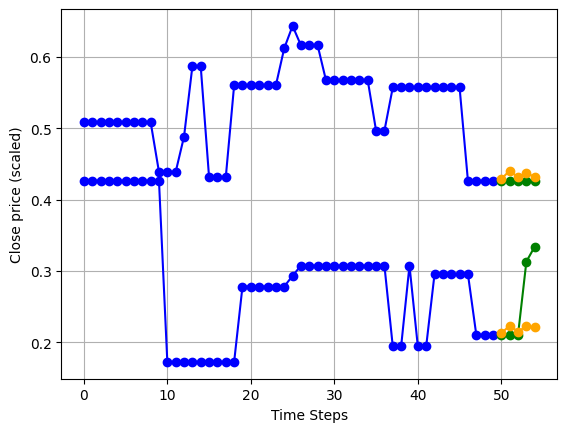

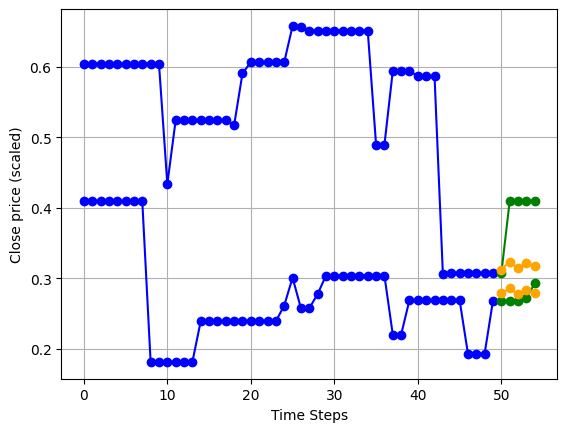

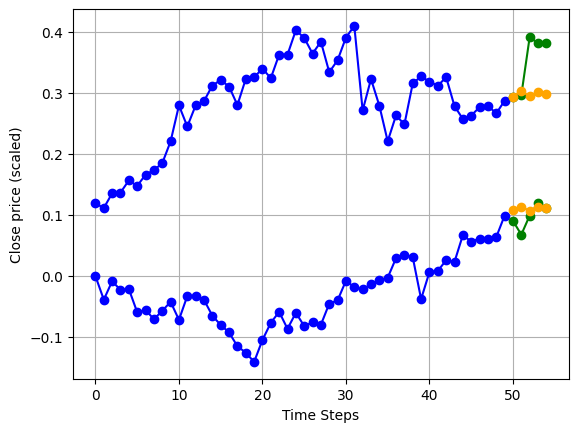

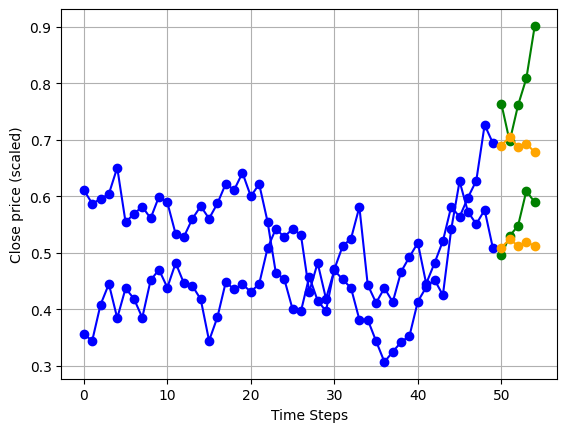

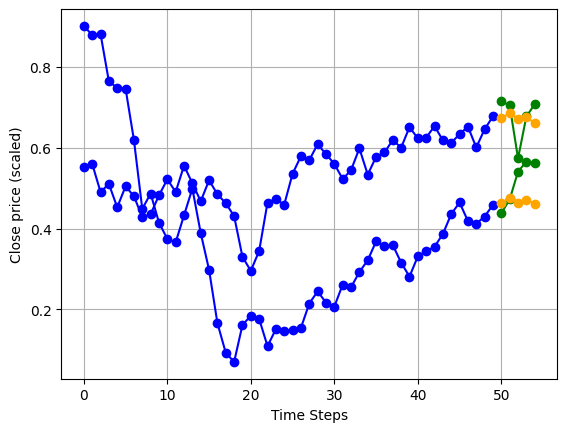

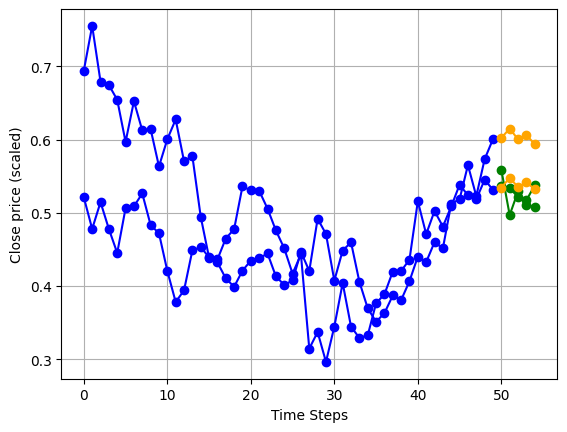

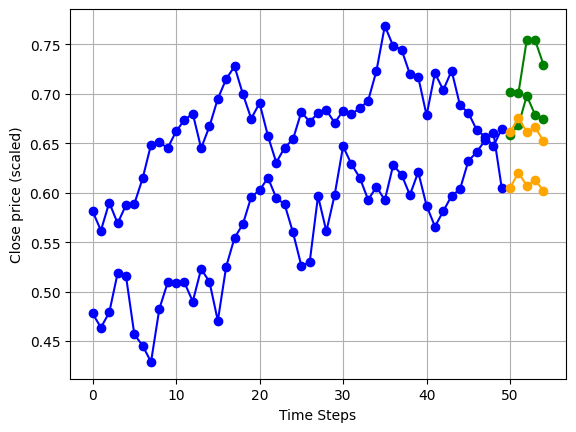

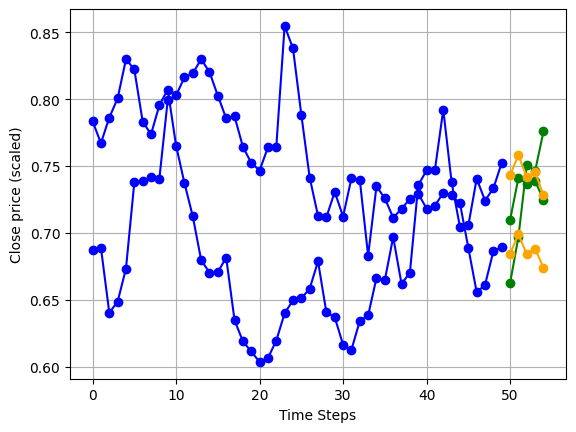

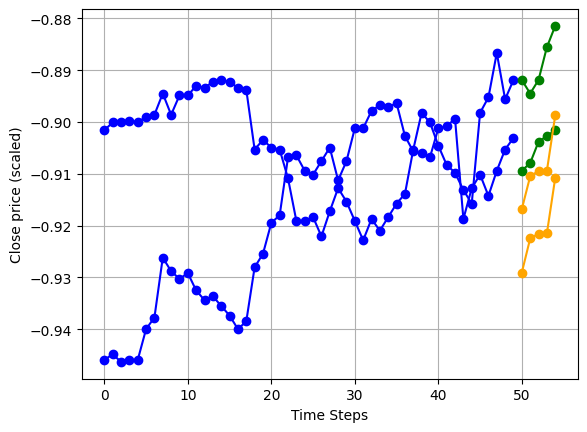

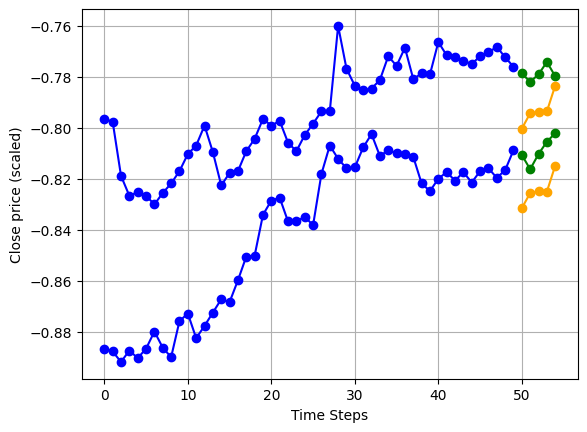

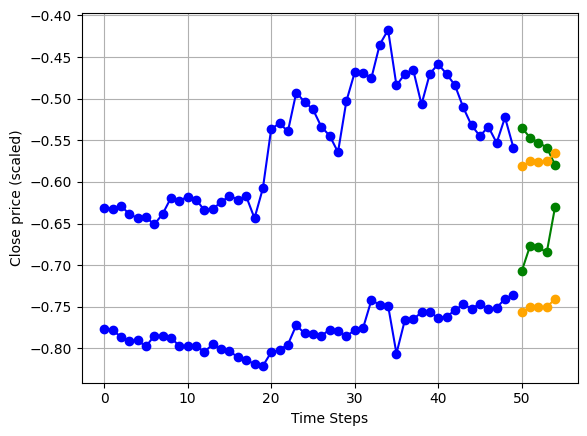

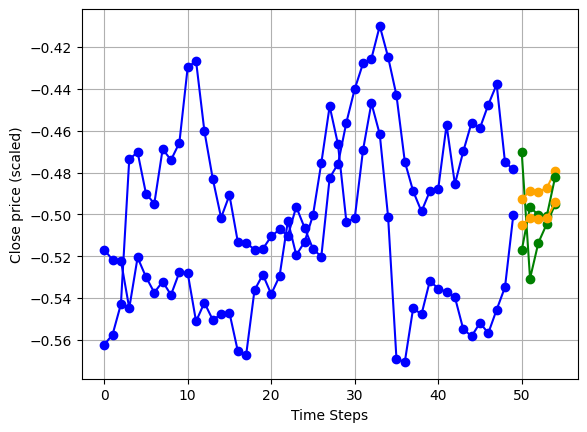

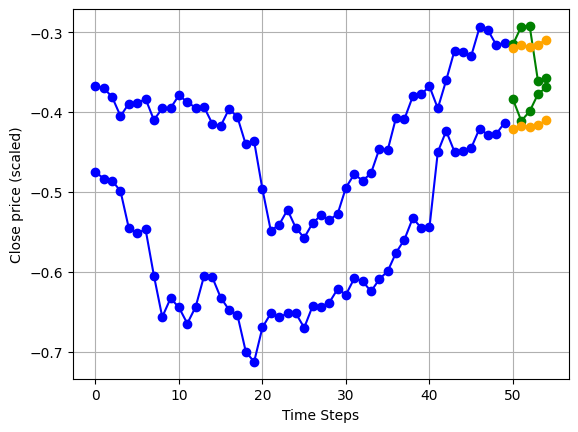

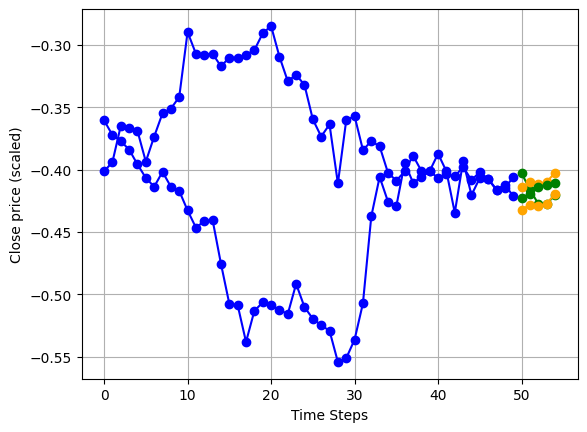

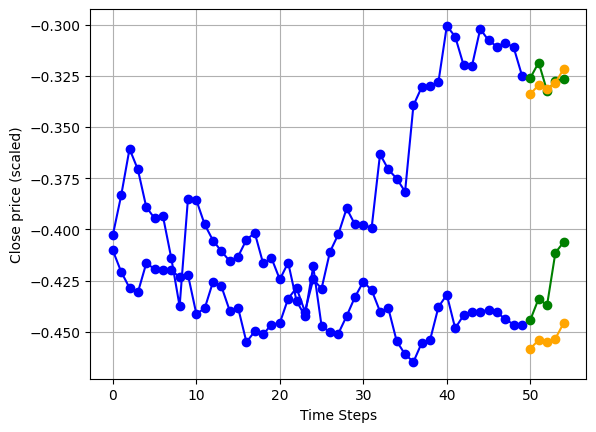

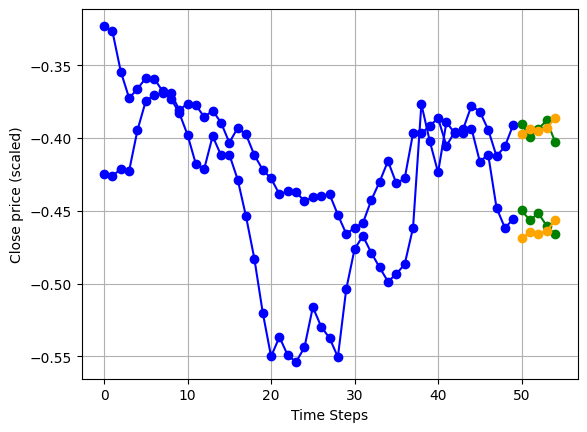

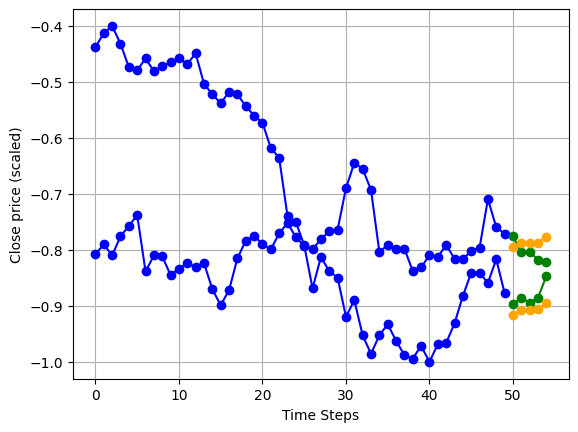

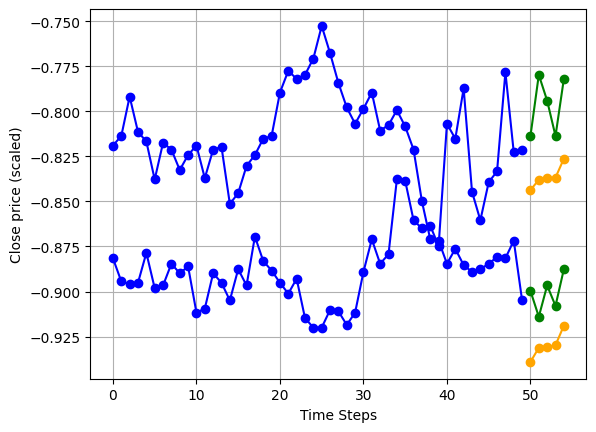

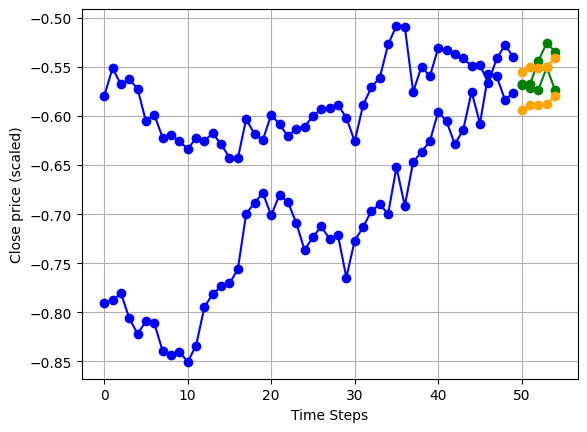

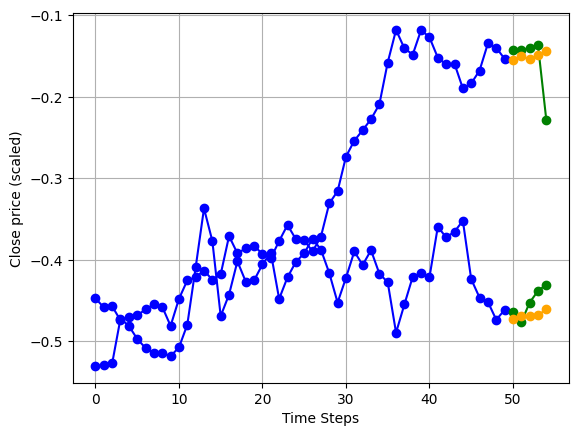

<Figure size 640x480 with 0 Axes>

In [9]:
from stat3007_timeseries_forecasting.utils import plot_predictions
plot_predictions(test_sequences[100:150], predictions[100:150], sequences_per_plot=2)